Python 3.10.12
/home/nikto/study/mlops-zoomcamp/02-experiment-tracking


/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/tmp/ipykernel_60299/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_60299/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an ax

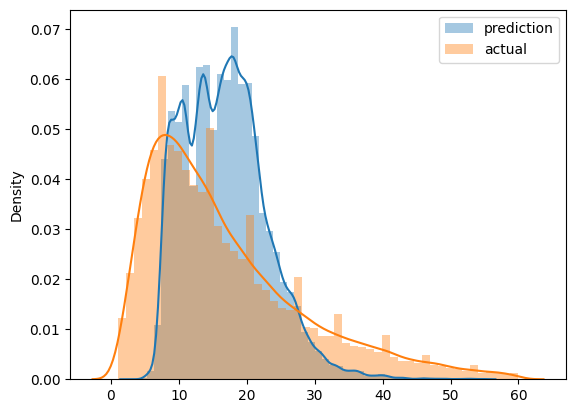

/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:
%run "2.2 Getting started with MLflow.ipynb"

['PU_DO']

In [8]:
import xgboost as xgb

In [9]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [17]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


In [14]:
def objective(x):
    return (x-8) ** 2 + 2

# define a search space
space = hp.uniform('x', -10, 10)

# minimize the objective over the space
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

print(best, objective(best['x']))

100%|██████████| 100/100 [00:00<00:00, 1229.52trial/s, best loss: 2.0001550236861476]
{'x': 8.012450850820237} 2.0001550236861476


In [18]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [19]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), #exp(-3), exp(0) - [.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:32:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.77557                          
[1]	validation-rmse:9.67336                           
[2]	validation-rmse:8.84011                           
[3]	validation-rmse:8.21872                           
[4]	validation-rmse:7.75864                           
[5]	validation-rmse:7.42340                           
[6]	validation-rmse:7.17895                           
[7]	validation-rmse:7.00340                           
[8]	validation-rmse:6.87565                           
[9]	validation-rmse:6.77850                           
[10]	validation-rmse:6.70739                          
[11]	validation-rmse:6.65455                          
[12]	validation-rmse:6.61300                          
[13]	validation-rmse:6.58075                          
[14]	validation-rmse:6.55512                          
[15]	validation-rmse:6.53486                          
[16]	validation-rmse:6.51996                          
[17]	validation-rmse:6.50665                          
[18]	valid

In [ ]:
mlflow.xgboost.autolog(disable=True)

In [ ]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[11:40:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.48425
[1]	validation-rmse:17.95634
[2]	validation-rmse:16.59114
[3]	validation-rmse:15.37412
[4]	validation-rmse:14.29011
[5]	validation-rmse:13.32800
[6]	validation-rmse:12.47570
[7]	validation-rmse:11.72140
[8]	validation-rmse:11.05888
[9]	validation-rmse:10.47583
[10]	validation-rmse:9.96483
[11]	validation-rmse:9.51784
[12]	validation-rmse:9.12620
[13]	validation-rmse:8.78522
[14]	validation-rmse:8.49037
[15]	validation-rmse:8.23332
[16]	validation-rmse:8.01179
[17]	validation-rmse:7.81822
[18]	validation-rmse:7.65209
[19]	validation-rmse:7.50743
[20]	validation-rmse:7.38235
[21]	validation-rmse:7.27382
[22]	validation-rmse:7.17865
[23]	validation-rmse:7.09606
[24]	validation-rmse:7.02481
[25]	validation-rmse:6.96336
[26]	validation-rmse:6.91001
[27]	valid

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

/Users/cristian.martinez/miniconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
